<a href="https://colab.research.google.com/github/aslinura/Airbnb_NYC_Price_Prediction/blob/main/Airbnb_4_Other_Modelling_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BrainStation Capstone Project**   

---



### **Airbnb Price Prediction in NYC** 

Sole contributor: Aslinur Acarlioglu

Date: August 28, 2022

Notebook: 4 of 4

#### **RECAP**

In the previous notebook,The lowest Mean Absolute Error (MAE) score we're able to achieve was and the highest R^2 score were $47 and 59%. The Lasso model was not overfitting. 

###▶ **NOTEBOOK 4: MODELLING | RANDOM FOREST & XGBOOST & LIGHTGBM REGRESSION MODELS**


---
The purpose is to fit the datasets to Random Forest, XGBOOST, and LightGBM Regression Models and optimize the models to achieve the lowest Mean Absolute Error score and the highest R^2 score by ensuring that the final model does not overfit.


Let's get started with importing the required packages:

In [ ]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [ ]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

# Import required libraries

import gzip
import shutil

import numpy as np
import pandas as pd


# Plotting
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix


from sklearn.model_selection import GridSearchCV,RepeatedKFold,StratifiedKFold, RandomizedSearchCV
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score


# Model Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,median_absolute_error,mean_absolute_percentage_error
from scipy import stats


# Building models
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn import ensemble


# Pipeline 
from tempfile import mkdtemp
cachedir = mkdtemp()
from sklearn.pipeline import Pipeline


# Seed number
seed=42


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Create a seaborn countplot function, which counts the observations in each categorical bin using bar.
def perc_graph (variable, dataset, title):
    sns.set_style("white")    #have a white background
      # set plot dimensions
    Y = dataset[variable] #define column
    total = len(Y) #total number of the instances
    axis=sns.countplot(x=variable, data=dataset, palette="Set2") #define the x and y axis and decide the color set
    plt.title(title)
    plt.xlabel(variable)
    plt.ylabel('Number of Instances')
    
    for i in axis.patches:   #create patches to calculate the percentage of each column
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()


#Create a seaborn scatterplot graph function with hue=price to examine the distribution of disease presence in the selected variables
def scatter(dataset, variable_x, variable_y):
    sns.set_style("white")
    sns.scatterplot(x=dataset[variable_x],y=dataset[variable_y],hue=dataset['price'],palette="Set3")


#Create a seaborn countplot function with hue=WMNV to examine the disease presense distribution in the selected variable
def hue_graph(variable, dataset, title):
    sns.set_style("white")
    plt.figure(figsize=(8,8))
    Y= dataset[variable]
    total=len(Y)
    axis=sns.countplot(x=variable, data=dataset, hue="price", palette="Set3", order = dataset[variable].value_counts().index)
    plt.title(title, fontsize=15)
    plt.xlabel(variable)
    plt.ylabel('Number of Instances')
    for i in axis.patches:
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()


#Create a seaborn horizantal bar graph
def barh_graph (variable, dataset, title):
    sns.set_style("white")
    plt.figure(figsize=(15,5))  #graph size
    Y = dataset[variable] #define column
    total = len(Y) #total number of the instances
    axis=sns.countplot(y=variable, data=dataset, palette="Set3", order = dataset[variable].value_counts().index) #defining the axis x and y  #sns refers to the statistical graph
    plt.title(title, fontsize=15)
    plt.xlabel('Number of Instances')
    plt.ylabel(variable, size=12)
    plt.show()

    
#Create a kernel density estimate (KDE) seaborn plot to illustrate the distribution of all the mosquitoes caught in a single trap.
def kde(variable, dataset, title):
    sns.set(rc={"figure.figsize":(9, 6)})
    sns.kdeplot(data=dataset, x=variable, shade=True, color="r").set(title=title, xlabel=variable)
    
    
#Create a seaborn line plot to display the evaluation of one numerical variable over time so variable_x is going to be labeled with numerical columns including time values. 
def line(variable_x, variable_y, dataset, title):
    sns.set(rc={"figure.figsize":(8, 8)})
    sns.lineplot(x = variable_x, y = variable_y, data = dataset).set(title=title, ylabel=variable_y, xlabel=variable_x,)
    plt.xticks(rotation = 25)   #rotate the x axis values
    

def plot_coefficients(dataset,model_type):   
    
    plt.figure(figsize=(20,8))
    #Plot Searborn bar chart
    ax=dataset['coefficient'].head(40).plot(kind='bar', x=dataset['feature_name'],
                    color=(dataset['coefficient'] > 0).map({True: 'g',
                                                    False: 'r'}))
    #ax=sns.barplot(x=dataset['feature_name'].head(40), y=dataset['coefficient'].head(40),color=dataset.positive.map({True: 'g', False: 'r'}))
    #Add chart labels
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.title( model_type + ' FEATURE COEFFICIENTS')
    plt.ylabel('FEATURE COEFFICIENTS')
    plt.xlabel('FEATURE NAMES')

In [ ]:
# Please ensure that Brainstation Capstone Folder is uploaded to your drive
from google.colab import drive

drive.mount('/content/drive')

!ls "/content/drive/My Drive/Brainstation Capstone"

Mounted at /content/drive
 Aslinur_Acarlioglu_Capstone_Report.pdf   File_List_Aslinur_Acarlioglu.md
'Colab Notebooks'			  june_listings.csv.gz
 df_listing.csv				  X_data
 df_preprocessed_capped.csv		  y_data


In [ ]:
# Pull the preprocessed dataset
X_train=pd.read_csv('drive/My Drive/X_train.csv')
X_test=pd.read_csv('drive/My Drive/X_test.csv')


y_train=pd.read_csv('drive/My Drive/y_train.csv')
y_test=pd.read_csv('drive/My Drive/y_test.csv')

print(f'Recall the shape of the the preprocessed dataset: {X_train.shape}')
print(f'Recall the shape of the the preprocessed dataset: {X_test.shape}')
print('--------------')
print(f'Recall the shape of the the preprocessed dataset: {y_train.shape}')
print(f'Recall the shape of the the preprocessed dataset: {y_test.shape}')

Recall the shape of the the preprocessed dataset: (25107, 64)
Recall the shape of the the preprocessed dataset: (6277, 64)
--------------
Recall the shape of the the preprocessed dataset: (25107, 1)
Recall the shape of the the preprocessed dataset: (6277, 1)


In [ ]:
# Take the log of all dependent variables
y_log_train= np.log1p(y_train)
y_log_test= np.log1p(y_test)

Original `price` distribution:

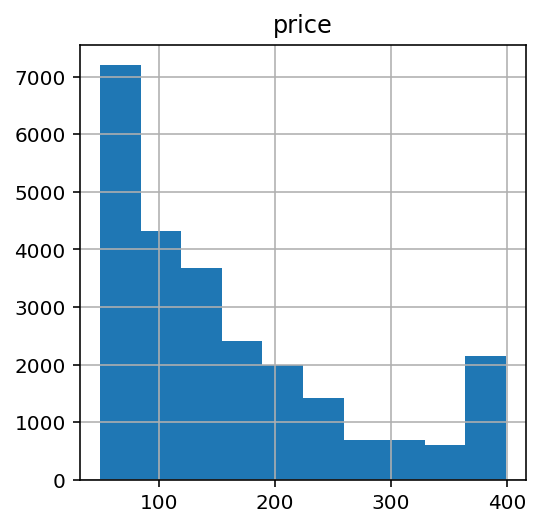

In [ ]:
y_train.hist(figsize=(4,4))
plt.show()

Here is the distribution after taking the log version of the price:

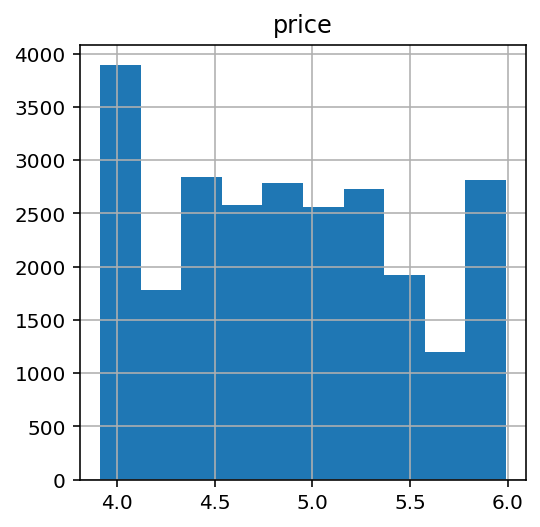

In [ ]:
y_log_train.hist(figsize=(4,4))
plt.show()

### **Principal Component Analysis (PCA):**
---



PCA technique is primarily used to reduce the computation cost by reducing the dimensionality in the dataset; however it helps to address the multicollinearity issue too. We may use this technique toward the end of the notebook.

In [ ]:
from tqdm import tqdm
lista = range(1,(len(X_train.columns)+1))   # select the number of the columns
aa=[]
bb=[]
for f in tqdm(lista):
    aa.append(f)
    pca = PCA(n_components=f).fit(X_train)  # Fit the train dataset
    
a = 0
for e in lista:
    a=a+pca.explained_variance_ratio_[e-1]    
    bb.append(a)

100%|██████████| 64/64 [00:17<00:00,  3.63it/s]


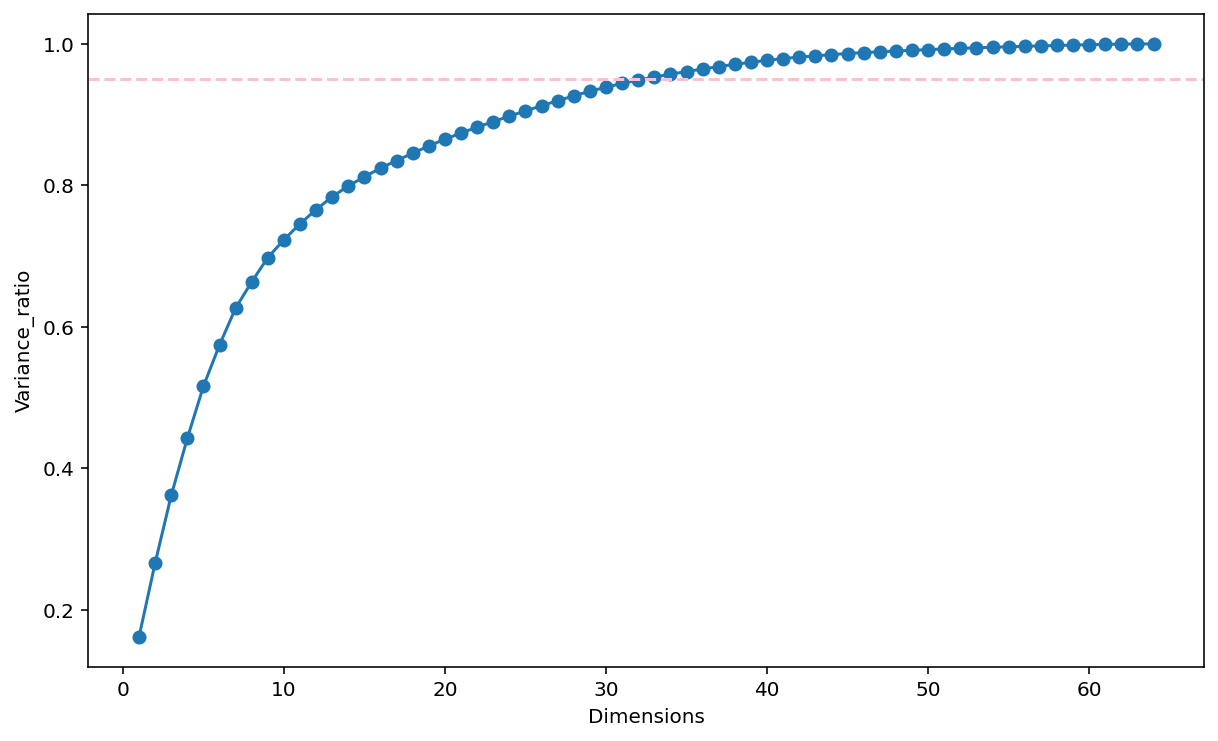

In [ ]:
# Plot PCA variance ratio
fig, ax = plt.subplots(figsize = (10,6))
plot = plt.plot(aa, bb, '-o')
plt.axhline(.95, linestyle='--', color='pink', label='95% cum. sum')
ax.set_xlabel("Dimensions")
ax.set_ylabel("Variance_ratio"); 

Only 32 features seem to be enough to explain 95% of the variance in the data.

In [ ]:
# Find the number of dimensions at 95% ratio
pca = PCA(n_components=32).fit(X_train)
print(sum(pca.explained_variance_ratio_)) 


0.9488971987813616


In [ ]:
# Apply PCA for dimension reduction but we will use them later
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

We may use the dimensionally reduced datasets later. 

# MODELLING:

---


Baseline Models: Fitting data to the Random Forest, XGBoost, Light GBM Regressor Models without taking the log version of the target variable:

In [ ]:
regressor = ['Random Forest', 'XGBoost', 'LightGBM']
models = [RandomForestRegressor(), XGBRegressor(),LGBMRegressor()]

train_r_squared = []
train_MAE = []

test_r_squared = []
test_MAE = []


for m in models:

    fitted_model=m.fit(X_train, y_train.values.ravel())
    y_pred=fitted_model.predict(X_test)
    y_train_pred=fitted_model.predict(X_train)


    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r_squared.append(train_r2)
    train_MAE.append(train_mae)

    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r_squared.append(test_r2)
    test_MAE.append(test_mae)




[20:56:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
basic_result_no_log = pd.DataFrame({'Train R squared':train_r_squared,'Test R squared':test_r_squared,'Train MAE':train_mae,'Test MAE':test_mae}, index=regressor)
round(basic_result_no_log,2)

,Train R squared,Test R squared,Train MAE,Test MAE
Random Forest,0.96,0.69,35.1,38.74
XGBoost,0.68,0.66,35.1,38.74
LightGBM,0.76,0.69,35.1,38.74


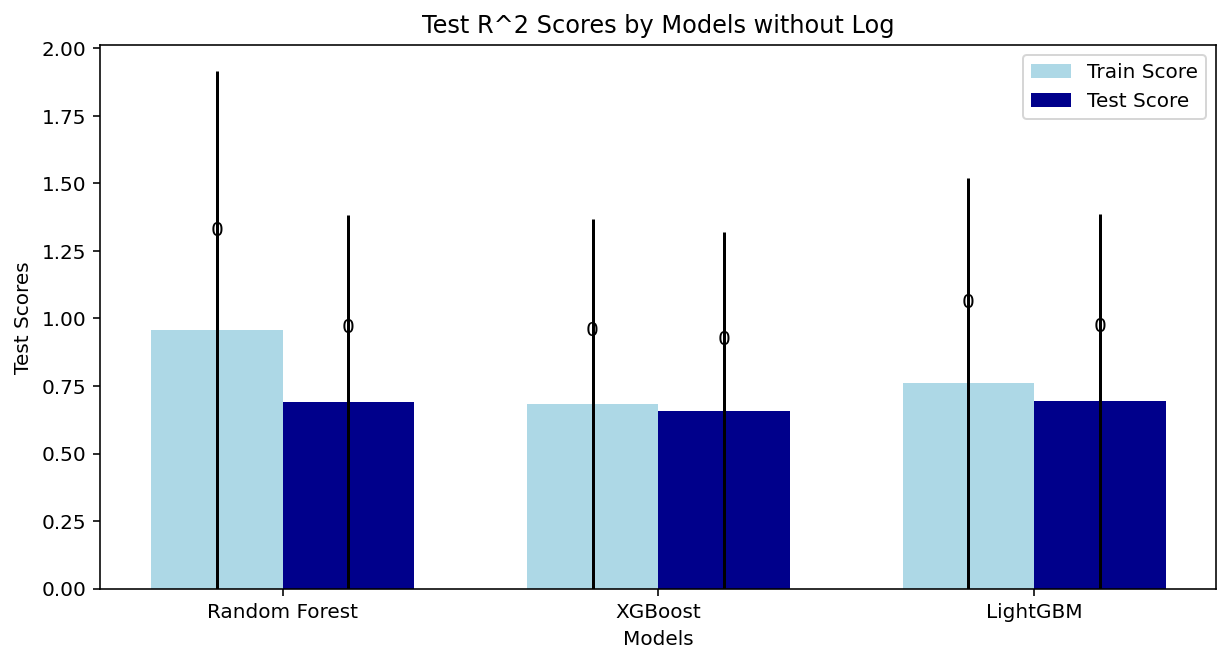

In [ ]:
width = 0.35  
plt.figure(figsize=(10,5))
rects1 = plt.bar(basic_result_no_log.index, basic_result_no_log['Train R squared'], -width, align='edge',
                yerr=basic_result_no_log['Train R squared'], color='lightblue', label='Train Score')


rects2 = plt.bar(basic_result_no_log.index, basic_result_no_log['Test R squared'], +width, align='edge',
                yerr=basic_result_no_log['Test R squared'], color='darkblue', label='Test Score')

# add some text for labels, title and axes ticks
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Train and Test R^2 Scores by Models without Log')
plt.ylim(ymin=0)
plt.legend()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.35*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

All models are overfiting. XGboost performs the best and has only 2% difference between train and test score rates and has 66% test r^2 score.

Baseline Models: Fitting data to the models after taking the log version of the target variable:

In [ ]:
regressor = ['Random Forest', 'XGBoost', 'LightGBM']
models = [RandomForestRegressor(), XGBRegressor(),LGBMRegressor()]

train_r_squared = []
train_MAE = []

test_r_squared = []
test_MAE = []


for m in models:


    model_optimized=m.fit(X_train, y_log_train.values.ravel())
    y_pred=model_optimized.predict(X_test)
    y_train_pred=model_optimized.predict(X_train)


    # Inverse log transformation
    y_train_rev=np.expm1(y_log_train.values.ravel())
    y_train_pred_rev=np.expm1(y_train_pred)

    y_test_rev=np.expm1(y_log_test.values.ravel())
    y_pred_rev=np.expm1(y_pred)


    train_r2 = r2_score(y_train_rev, y_train_pred_rev)
    train_mae = mean_absolute_error(y_train_rev, y_train_pred_rev)
    train_r_squared.append(train_r2)
    train_MAE.append(train_mae)


    test_r2 = r2_score(y_test_rev, y_pred_rev)
    test_mae = mean_absolute_error(y_test_rev, y_pred_rev)
    test_r_squared.append(test_r2)
    test_MAE.append(test_mae)





[20:59:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
basic_result_log = pd.DataFrame({'Train R squared':train_r_squared,'Test R squared':test_r_squared,'Train MAE':train_mae,'Test MAE':test_mae}, index=regressor)
round(basic_result_log,2)

,Train R squared,Test R squared,Train MAE,Test MAE
Random Forest,0.95,0.67,34.96,39.22
XGBoost,0.66,0.61,34.96,39.22
LightGBM,0.74,0.67,34.96,39.22


Let's compare scores of the models with and without log version of the price:

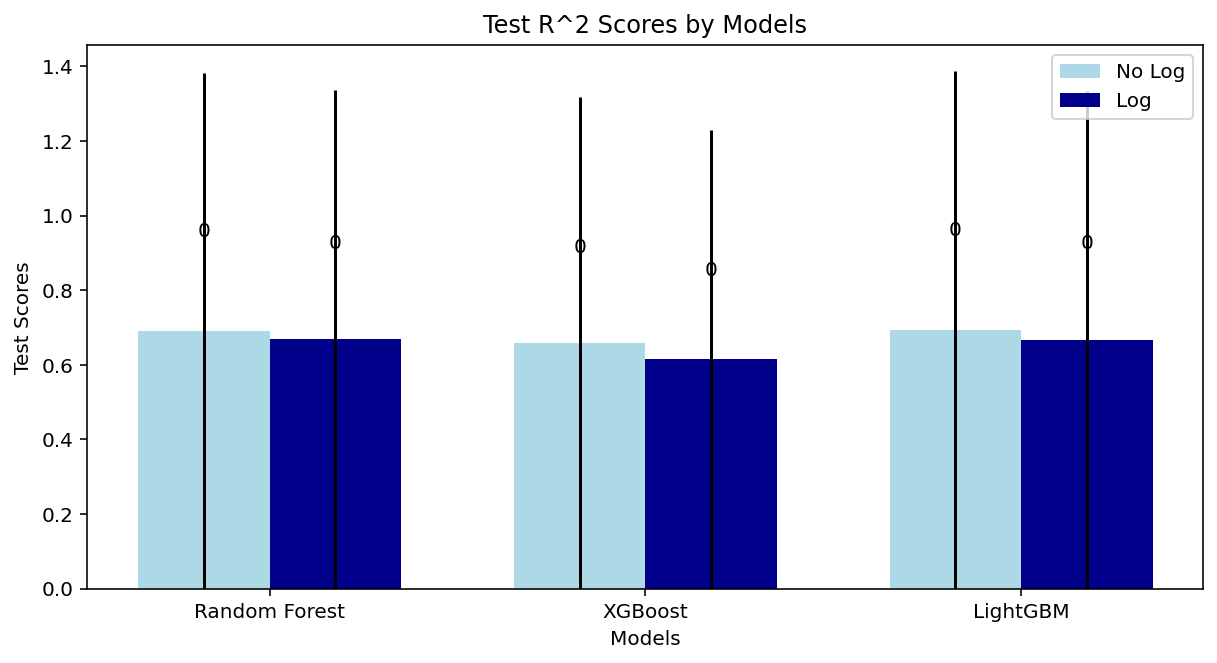

In [ ]:
width = 0.35  
plt.figure(figsize=(10,5))
rects1 = plt.bar(basic_result_no_log.index, basic_result_no_log['Test R squared'], -width, align='edge',
                yerr=basic_result_no_log['Test R squared'], color='lightblue', label='No Log')


rects2 = plt.bar(basic_result_log.index, basic_result_log['Test R squared'], +width, align='edge',
                yerr=basic_result_log['Test R squared'], color='darkblue', label='Log')

# add some text for labels, title and axes ticks
plt.xlabel('Models')
plt.ylabel('Test Scores')
plt.title('Test R^2 Scores by Models')
#plt.yscale('log')
plt.ylim(ymin=0)
plt.legend()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.35*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

Even though the log version of the target variable is taken, the models are overfitting worse so it would be better not to transform the target variable.Our second step is to optimize the hyperparameters of XGboost and LightGBM:

In [ ]:
# Create an empty model result table


results_table2 = pd.DataFrame(index=['Model', 'R^2', 'MAE'])
results_table2

""
Model
R^2
MAE


# 1. Random Forest Regression:

---



**Hyperparameter Tunning | Random Forest Regressor**

Even though we have used RandomizedSearch method, it takes a lot of time. It is not recommended to run it unless it is required.

In [ ]:

params = [
           {
            'n_estimators':[200, 400, 600],
            'min_samples_split':[5, 10],
            'min_samples_leaf': [4,16,48,96],
            'max_features': ['auto','sqrt'],
            'max_depth':[10, 20, 30, 40, 50, 60],
            'bootstrap':[True, False]
    
           }
    
]


ranfor = RandomForestRegressor(silent=True)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed) 

ranfor_clf = RandomizedSearchCV(estimator=ranfor, n_iter=20,cv=cv,
                   param_distributions=params,random_state=seed,
                   scoring='neg_mean_absolute_error', 
                   verbose=10)

fitted_clf=ranfor_clf.fit(X_train, y_train.values.ravel())

Fitting 30 folds for each of 10 candidates, totalling 300 fits
[CV 1/30; 1/10] START model=RandomForestRegressor(random_state=42), model__bootstrap=True, model__max_depth=50, model__max_features=sqrt, model__min_samples_leaf=96, model__min_samples_split=5, model__n_estimators=200
[CV 1/30; 1/10] END model=RandomForestRegressor(random_state=42), model__bootstrap=True, model__max_depth=50, model__max_features=sqrt, model__min_samples_leaf=96, model__min_samples_split=5, model__n_estimators=200;, score=0.618 total time=   0.9s
[CV 2/30; 1/10] START model=RandomForestRegressor(random_state=42), model__bootstrap=True, model__max_depth=50, model__max_features=sqrt, model__min_samples_leaf=96, model__min_samples_split=5, model__n_estimators=200
[CV 2/30; 1/10] END model=RandomForestRegressor(random_state=42), model__bootstrap=True, model__max_depth=50, model__max_features=sqrt, model__min_samples_leaf=96, model__min_samples_split=5, model__n_estimators=200;, score=0.569 total time=   0.8s
[CV

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=42),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions=[{'model': [RandomForestRegressor(max_depth=10,
                                                                         max_features='sqrt',
                                                                         min_samples_leaf=4,
                                                                         min_samples_split=10,
                                                                         n_estimators=600,
                                                                         random_state=42)],
                                         'model__bootstrap': [True, False],
                                         'model__max_depth': [10, 20, 30, 40,
                                                              50, 60],

In [ ]:
#checking the best score and parameter
print("Best parameters:", fitted_clf.best_params_)
print("Lowest NMAE: ", (fitted_clf.best_score_))

Best parameters: {'model__n_estimators': 600, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__bootstrap': True, 'model': RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=600, random_state=42)}
Lowest NMAE:  0.6948870995253992


In [ ]:


y_train_pred = fitted_clf.predict(X_train)
y_pred = fitted_clf.predict(X_test)

# Inverse the log transformation
y_train_rev=np.expm1(y_log_train)
y_train_pred_rev=np.expm1(y_train_pred)

y_test_rev=np.expm1(y_log_test)
y_pred_rev=np.expm1(y_pred)





# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train_rev,y_train_pred_rev),2)
test_mean=round(mean_absolute_error(y_test_rev, y_pred_rev),2)

# Define r2 
train_r=r2_score(y_train_rev,y_train_pred_rev)
test_r=r2_score(y_test_rev,y_pred_rev)

n_train=len(X_train)
p_train=len(X_train.columns)

n_test=len(X_test)
p_test=len(X_test.columns)

Adj_train_r2 = 1-(1-train_r)*(n_train-1)/(n_train-p_train) 
Adj_test_r2 = 1-(1-test_r)*(n_test-1)/(n_test-p_test) 


train_r2=round(Adj_train_r2 ,2)
test_r2=round(Adj_test_r2,2)




#print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set r2 score: {train_r2}')

print(f'Test set r2 score: {test_r2}')


In [ ]:

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) 

# Build the model with optimal parameters
optimal_rfr = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=40,
                      min_samples_split=10, n_estimators=600, random_state=42)



mean_val_scores = cross_val_score(optimal_rfr, X_train, y_log_train.values.ravel(), cv = cv, scoring='neg_mean_absolute_error')

# Fit and predict
fitted_model=optimal_rfr.fit(X_train, y_log_train.values.ravel())
y_pred = fitted_model.predict(X_test)
y_train_pred = fitted_model.predict(X_train)

# Inverse the log transformation
y_train_rev=np.expm1(y_log_train)
y_train_pred_rev=np.expm1(y_train_pred)

y_test_rev=np.expm1(y_log_test)
y_pred_rev=np.expm1(y_pred)




# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train_rev,y_train_pred_rev),2)
test_mean=round(mean_absolute_error(y_test_rev, y_pred_rev),2)

# Define r2 
train_r=r2_score(y_train_rev,y_train_pred_rev)
test_r=r2_score(y_test_rev,y_pred_rev)

n_train=len(X_train)
p_train=len(X_train.columns)

n_test=len(X_test)
p_test=len(X_test.columns)

Adj_train_r2 = 1-(1-train_r)*(n_train-1)/(n_train-p_train) 
Adj_test_r2 = 1-(1-test_r)*(n_test-1)/(n_test-p_test) 


train_r2=round(Adj_train_r2 ,2)
test_r2=round(Adj_test_r2,2)





print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set adjusted r2 score: {train_r2}')

print(f'Test set adjusted r2 score: {test_r2}')


Mean Cross Validation NMAE Score: -0.3
-------------------
Train set Mean AE: 46.56
Test set Mean AE: 49.83
-------------------
Train set r2 score: 0.55
Test set r2 score: 0.48


Despite the hyperparameter tunning, the model is still overfitting and has low R^2 score.

In [ ]:
results_table2['Random_Forest_Regression'] = ['Random_Forest_optimized', 0.59, 38.55]

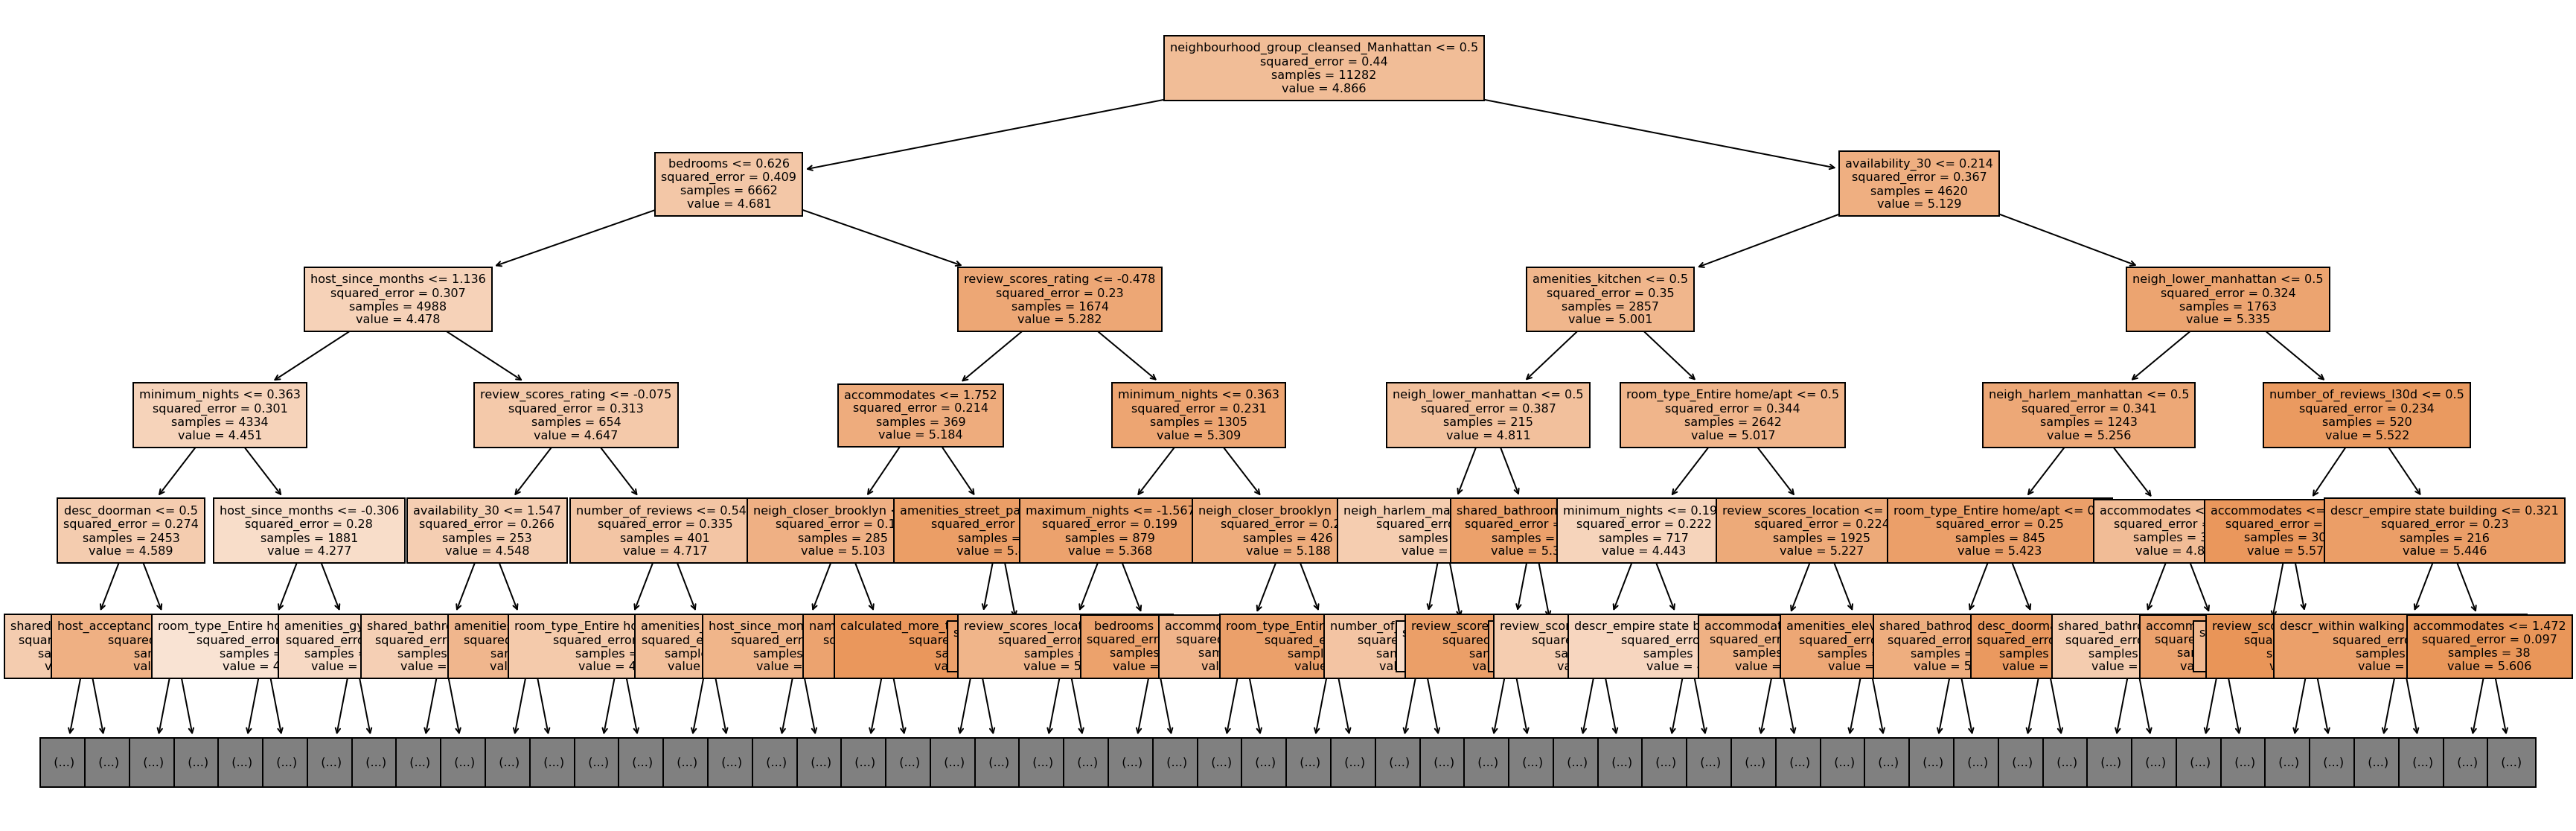

In [ ]:
plt.figure(figsize=(30,10))
tree.plot_tree(fitted_model.estimators_[0],
               feature_names=X_train.columns,
               max_depth = 5,
               filled=True,
              fontsize = 8)
plt.show()

Entire homes feature was the most important determinant based on the Random Forest Regressor Model which is followed by number of listings per host which improved the price. Under this branch we can see the significance of amenities. mostly on the higher price.

# 2. XGBOOST Regression:

---



**Hyperparameter Tunning along with Cross Validation | XGBoost Regressor**

Cross Validation will help us to spread the 
Even though we have used RandomizedSearch method, it takes a lot of time. It is not recommended to run it unless it is required. 

In [ ]:
params = { 'booster':['gbtree','dart','gblinear'],
           'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.5],  #0.3
           'subsample': [0.5, 1.0, 0.1],
           'colsample_bytree': [0.4, 1.0, 0.1],
           'colsample_bylevel': [0.4, 1.0, 0.1],
           'n_estimators': [100,200,300, 500,700]}

xgbr = XGBRegressor(silent=True)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed) 

xgb_clf = RandomizedSearchCV(estimator=xgbr, n_iter=20,cv=cv,
                   param_distributions=params,random_state=seed,
                   scoring='neg_mean_absolute_error', 
                   verbose=10)

fitted_xgb_clf=xgb_clf.fit(X_train, y_train)

Fitting 15 folds for each of 20 candidates, totalling 300 fits
[CV 1/15; 1/20] START booster=gblinear, colsample_bylevel=0.1, colsample_bytree=0.1, learning_rate=0.5, max_depth=15, n_estimators=500, subsample=1.0
[CV 1/15; 1/20] END booster=gblinear, colsample_bylevel=0.1, colsample_bytree=0.1, learning_rate=0.5, max_depth=15, n_estimators=500, subsample=1.0;, score=-63.082 total time=   9.5s
[CV 2/15; 1/20] START booster=gblinear, colsample_bylevel=0.1, colsample_bytree=0.1, learning_rate=0.5, max_depth=15, n_estimators=500, subsample=1.0
[CV 2/15; 1/20] END booster=gblinear, colsample_bylevel=0.1, colsample_bytree=0.1, learning_rate=0.5, max_depth=15, n_estimators=500, subsample=1.0;, score=-63.091 total time=   8.1s
[CV 3/15; 1/20] START booster=gblinear, colsample_bylevel=0.1, colsample_bytree=0.1, learning_rate=0.5, max_depth=15, n_estimators=500, subsample=1.0
[CV 3/15; 1/20] END booster=gblinear, colsample_bylevel=0.1, colsample_bytree=0.1, learning_rate=0.5, max_depth=15, n_est

In [ ]:

print("Best parameters:", fitted_xgb_clf.best_params_)
print("Lowest NMAE: ", (fitted_xgb_clf.best_score_))


Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'booster': 'gbtree'}
Lowest NMAE:  -37.653071496198145


In [ ]:


y_train_pred = fitted_xgb_clf.predict(X_train)
y_pred = fitted_xgb_clf.predict(X_test)


# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train,y_train_pred),2)
test_mean=round(mean_absolute_error(y_test, y_pred),2)

# Define r2 
train_r=r2_score(y_train,y_train_pred)
test_r=r2_score(y_test,y_pred)

n_train=len(X_train)
p_train=len(X_train.columns)

n_test=len(X_test)
p_test=len(X_test.columns)

Adj_train_r2 = 1-(1-train_r)*(n_train-1)/(n_train-p_train) 
Adj_test_r2 = 1-(1-test_r)*(n_test-1)/(n_test-p_test) 


train_r2=round(Adj_train_r2 ,2)
test_r2=round(Adj_test_r2,2)




#print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set r2 score: {train_r2}')

print(f'Test set r2 score: {test_r2}')


-------------------
Train set Mean AE: 28.47
Test set Mean AE: 38.58
-------------------
Train set r2 score: 0.84
Test set r2 score: 0.69


## 4. LightGBM Regressor:

---




In [ ]:
params = [
           {
            'booster': ['gbdt', 'dart','goss','rf'],  #dart may be used to improve the scores
            'max_depth': [3,4,5,6,7,9],
           'learning_rate': [0.005,0.05],
            'num_leaves':[16,24,32,64,84,96,128,256],
            'n_estimators': [300,400,500,600,700],
            #'min_child_sample': [10,20,30,50,150],  
            #'min_child_weight': [1e-3,1e-5,1e-7,1e-1],  
            #'colsample_bytree': [0.8],
            #'min_data_in_leaf':[20,40,60,100,200,300],
            #'max_bin':[50,100,150,200,255,500],
            #'bagging_fraction':[0.8],
            #'bagging_freq':[10],
            'reg_lambda':[10,15,20,25,30],
            'reg_alpha':[10,15,20,25,30,35],
            'min_split_loss':[0,5,10,15,20,15,30,40,50,60],
            
           }
    
]

lgbm=LGBMRegressor(random_state=seed)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)  

lgbm_clf = RandomizedSearchCV(estimator=lgbm, cv=cv,n_iter=20,
                   param_distributions=params,random_state=seed,
                   scoring='neg_mean_absolute_error',verbose=10)

fitted_lgbm_clf=lgbm_clf.fit(X_train, y_train)



Fitting 15 folds for each of 20 candidates, totalling 300 fits
[CV 1/15; 1/20] START model=LGBMRegressor(random_state=42), model__booster=gbdt, model__learning_rate=0.05, model__max_depth=7, model__min_split_loss=5, model__n_estimators=600, model__num_leaves=24, model__reg_alpha=15, model__reg_lambda=25
[CV 1/15; 1/20] END model=LGBMRegressor(random_state=42), model__booster=gbdt, model__learning_rate=0.05, model__max_depth=7, model__min_split_loss=5, model__n_estimators=600, model__num_leaves=24, model__reg_alpha=15, model__reg_lambda=25;, score=-37.457 total time=   3.1s
[CV 2/15; 1/20] START model=LGBMRegressor(random_state=42), model__booster=gbdt, model__learning_rate=0.05, model__max_depth=7, model__min_split_loss=5, model__n_estimators=600, model__num_leaves=24, model__reg_alpha=15, model__reg_lambda=25
[CV 2/15; 1/20] END model=LGBMRegressor(random_state=42), model__booster=gbdt, model__learning_rate=0.05, model__max_depth=7, model__min_split_loss=5, model__n_estimators=600, mo

In [ ]:

print("Best parameters:", fitted_lgbm_clf.best_params_)
print("Lowest NMAE: ", (fitted_clf1.best_score_))



Best parameters: {'model__reg_lambda': 20, 'model__reg_alpha': 30, 'model__num_leaves': 96, 'model__n_estimators': 700, 'model__min_split_loss': 60, 'model__max_depth': 7, 'model__learning_rate': 0.05, 'model__booster': 'gbdt', 'model': LGBMRegressor(booster='gbdt', learning_rate=0.05, max_depth=7,
              min_split_loss=60, n_estimators=700, num_leaves=96,
              random_state=42, reg_alpha=30, reg_lambda=20)}
Lowest NMAE:  -37.41441896824881


In [ ]:


y_train_pred = fitted_lgbm_clf.predict(X_train)
y_pred = fitted_lgbm_clf.predict(X_test)


# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train,y_train_pred),2)
test_mean=round(mean_absolute_error(y_test, y_pred),2)

# Define r2 
train_r=r2_score(y_train,y_train_pred)
test_r=r2_score(y_test,y_pred)

n_train=len(X_train)
p_train=len(X_train.columns)

n_test=len(X_test)
p_test=len(X_test.columns)

Adj_train_r2 = 1-(1-train_r)*(n_train-1)/(n_train-p_train) 
Adj_test_r2 = 1-(1-test_r)*(n_test-1)/(n_test-p_test) 


train_r2=round(Adj_train_r2 ,2)
test_r2=round(Adj_test_r2,2)




#print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set r2 score: {train_r2}')

print(f'Test set r2 score: {test_r2}')


-------------------
Train set Mean AE: 28.81
Test set Mean AE: 37.96
-------------------
Train set r2 score: 0.83
Test set r2 score: 0.7


In [ ]:




cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) 

# Build the model with optimal parameters
optimal_lgbm = LGBMRegressor(booster='gbdt', learning_rate=0.05, max_depth=7,
              min_split_loss=10, n_estimators=700, num_leaves=64,
              random_state=42, reg_alpha=20, reg_lambda=20)



mean_val_scores = cross_val_score(optimal_lgbm, X_train, y_train, cv = cv, scoring='neg_mean_absolute_error')

# Fit and predict
fitted_model=optimal_lgbm.fit(X_train, y_train)
y_pred = fitted_model.predict(X_test)
y_train_pred = fitted_model.predict(X_train)





# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train,y_train_pred),2)
test_mean=round(mean_absolute_error(y_test, y_pred),2)

# Define r2 
train_r2=round(r2_score(y_train,y_train_pred),2)
test_r2=round(r2_score(y_test,y_pred),2)




print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set r2 score: {train_r2}')

print(f'Test set r2 score: {test_r2}')

Mean Cross Validation NMAE Score: -37.14
-------------------
Train set Mean AE: 29.02
Test set Mean AE: 37.91
-------------------
Train set r2 score: 0.83
Test set r2 score: 0.7


### **4b.** LightGBM with the optimal parameter group:

---




The least mean absolute error we have got with LightGBM is 41.29 US dollars. Although the R^2 score has increased, our model is overfitting. Since we included lots of parameters and had to use Randomized Search CV method to reduce the computation time, the function doesn't check every possible parameter group. To resolve overfitting issue we can do some of the following adjustments manually:

- Use small `max_bin` (default 255)
- Reduce `num_leaves`
- Use `min_data_in_leaf` and `min_sum_hessian_in_leaf`
- Use bagging by set `bagging_fraction` and `bagging_freq`
- Try `lambda 1 & 2` and `min_gain_to_split`
- Use feature sub-sampling by set `feature_fraction`
- Use bigger training data


It is also necessary to tune num_leaves with the max_depth together. Simple rule is = 2^(max_depth) but we will use half of this amount.

Manually Adjusted LightGBM:

In [ ]:




cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed) 

# Build the model with optimal parameters
optimal_lgbm = LGBMRegressor(booster='dart', learning_rate=0.05, max_depth=6,
              min_split_loss=5, n_estimators=700, num_leaves=32,
              random_state=42, reg_alpha=15, reg_lambda=25)



mean_val_scores = cross_val_score(optimal_lgbm, X_train, y_log_train, cv = cv, scoring='neg_mean_absolute_error')

# Fit and predict
fitted_model=optimal_lgbm.fit(X_train, y_log_train)
y_pred = fitted_model.predict(X_test)
y_train_pred = fitted_model.predict(X_train)

# Inverse the log transformation
y_train_rev=np.expm1(y_log_train)
y_train_pred_rev=np.expm1(y_train_pred)

y_test_rev=np.expm1(y_log_test)
y_pred_rev=np.expm1(y_pred)





# Define mean absolute error metrics
train_mean=round(mean_absolute_error(y_train_rev,y_train_pred_rev),2)
test_mean=round(mean_absolute_error(y_test_rev, y_pred_rev),2)

# Define r2 
train_r2=round(r2_score(y_train_rev,y_train_pred_rev),2)
test_r2=round(r2_score(y_test_rev,y_pred_rev),2)




print(f'Mean Cross Validation NMAE Score: {round(mean_val_scores.mean(),2)}')

print('-------------------')

print(f'Train set Mean AE: {train_mean}')
print(f'Test set Mean AE: {test_mean}')

print('-------------------')

print(f'Train set r2 score: {train_r2}')

print(f'Test set r2 score: {test_r2}')

Mean Cross Validation NMAE Score: -0.25
-------------------
Train set Mean AE: 38.42
Test set Mean AE: 43.69
-------------------
Train set r2 score: 0.71
Test set r2 score: 0.61


----

In [ ]:
results_table2['Light_GBM_Regression'] = ['LightGBM_optimized', 0.65, 39.93]

In [ ]:

# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# generate dataset
X_train, y_log_train = make_regression(n_samples=100, n_features=100, n_informative=10)
# define feature selection
fs = SelectKBest(score_func=f_regression, k=10)
# apply feature selection
X_selected = fs.fit_transform(X_train, y_log_train)
print(X_selected.shape)


(100, 10)


We can observe the variance in residuals.

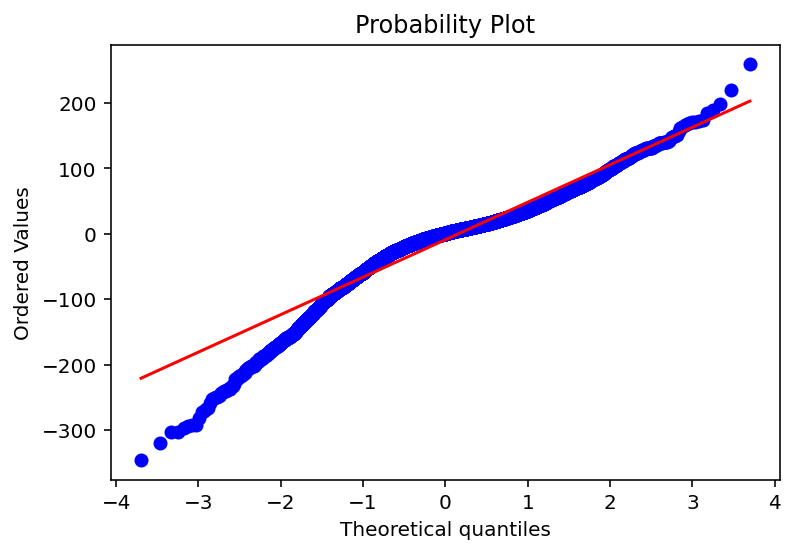

In [ ]:
stats.probplot((y_pred_rev.flatten()-y_test_rev.values.flatten()), dist='norm', plot=plt)
plt.show()

Let's plot the first 50 actual and predicted listing prices:

In [ ]:
#Flatten the y_pred array and y_test dataframe
test = pd.DataFrame({'Predicted value':y_pred_rev.flatten(), 'Actual value':y_test_rev.values.flatten()})
fig= plt.figure(figsize=(30,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:150])
plt.title('Actual Price vs Predicted Price')
plt.legend(['Actual Price','Predicted Price'])

AttributeError: ignored

We can observe the errors at medium level prices; where the model predicts higher than the actual price.

In [ ]:
# Quick look at the feature importance values
optimal_lgbm.feature_importances_

array([ 31,  63,  17,   2,  61,  28,  39, 128,  60,  46,  35,  20,  51,
       113,  45,   0,  16,  58,  34,  27,   3,  48,  28,  54,  37,   6,
        77,   6,  28,   0,   1,   0,   1,  13,   9,  25,  56,  10,  35,
        14,   0,  32,  34,   4,  27,   0,  13,  23,  48, 118,  18,  42,
        75, 196, 361, 261, 338, 120, 175, 391, 553, 319])

Let's compile the most important features according to LightGBM:

In [ ]:
feature_importance = optimal_lgbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / sum(feature_importance))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]

var_df=pd.DataFrame({'pcols':pcols,'pvals':pvals}).sort_values(by=['pvals'],ascending=False)

var_df.head(20)


,pcols,pvals
61,listing_per_neighborhood,12.363067
60,host_since_months,8.741337
59,availability_30,8.070646
58,minimum_nights,7.556450
57,accommodates,7.131679
56,number_of_reviews,5.835010
55,review_scores_location,4.381847
54,review_scores_value,3.912363
53,neigh_harlem_manhattan,2.861614
52,maximum_nights,2.682763


## LightGBM | Detailed Feature Importance:


In [ ]:
def plot_features(dataset,title):    
    plt.figure(figsize=(6,6))
    #Plot Searborn bar chart
    sns.barplot(x=dataset['pvals'].head(40), y=dataset['pcols'].head(40))
    #Add chart labels
    plt.title('LIGHTGBM Regressor |' + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

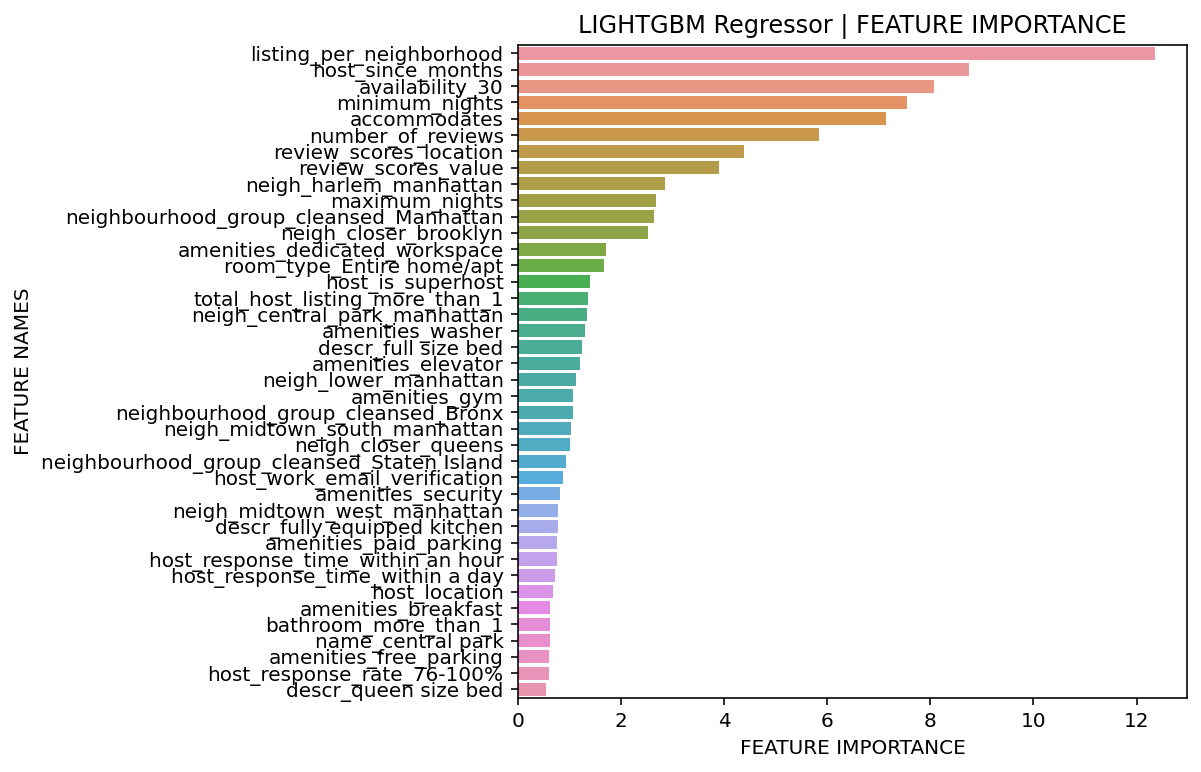

In [ ]:
plot_features(var_df,'LightGBM Regressor Feature Importance List')

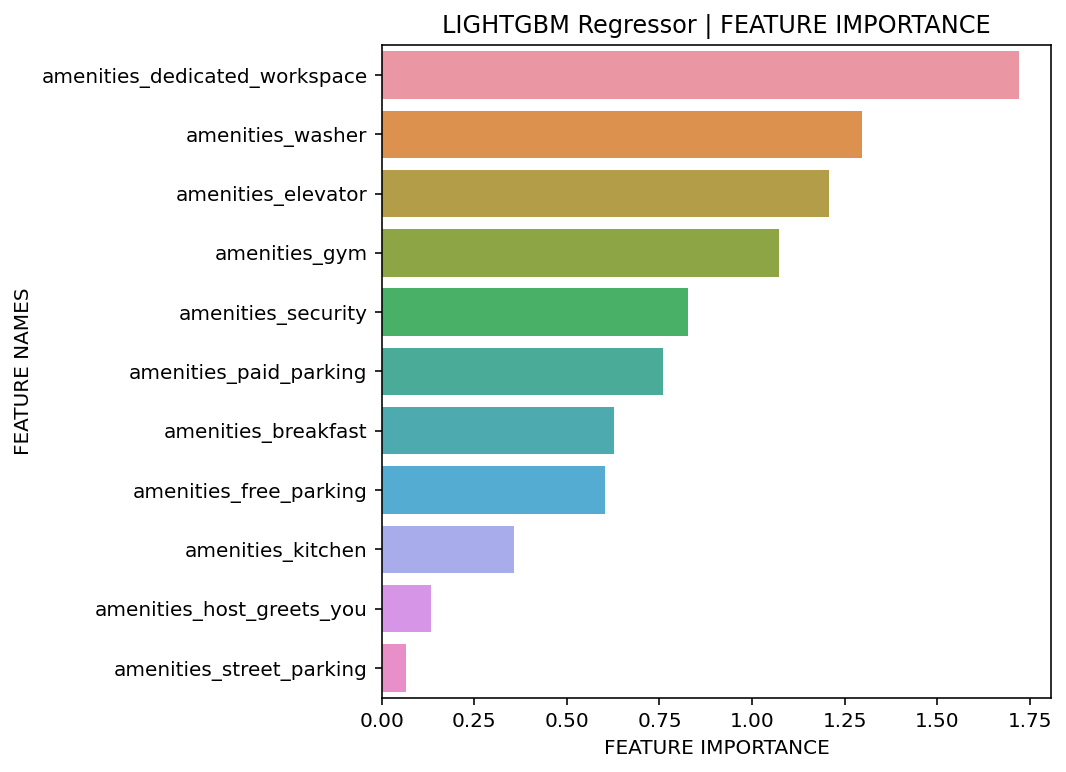

In [ ]:
amenities_df = var_df[var_df.pcols.str.startswith('amenities_')]

plot_features(amenities_df,'LGBM Regressor - Amenities')

Again washer, gym, dedicated workspace are the crucial amenities. Parking seems to be important too.

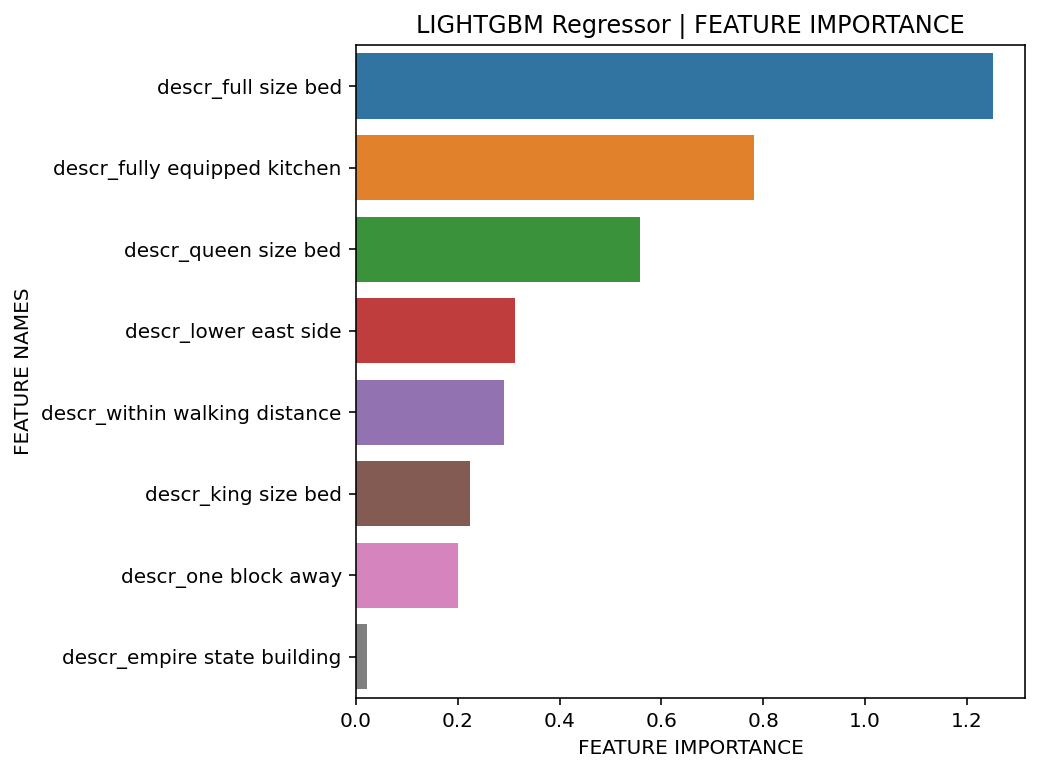

In [ ]:
description_df = var_df[var_df.pcols.str.startswith('desc')]

plot_features(description_df,'LGBM Regressor -  Description NLP')

Probably the queen size bed and upper west tend to impact the price negatively. 

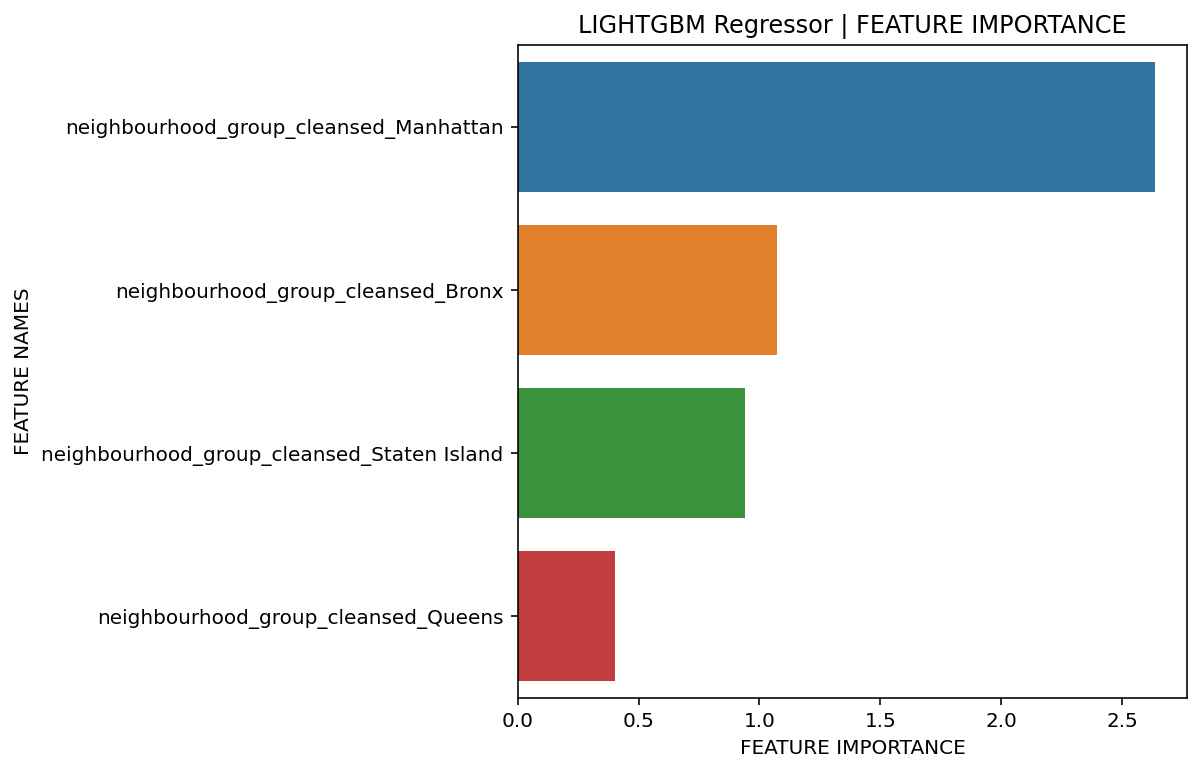

In [ ]:
neighbourhood_df = var_df[var_df.pcols.str.startswith('neighbourhood_group_')]

plot_features(neighbourhood_df,'LGBM Regressor - Borough')

If the property is located in Manhattan, it is more likely to be listed at a higher price; however we cannot interpret if other neighborhoods influence the price in a positive way too. We will figure out later.

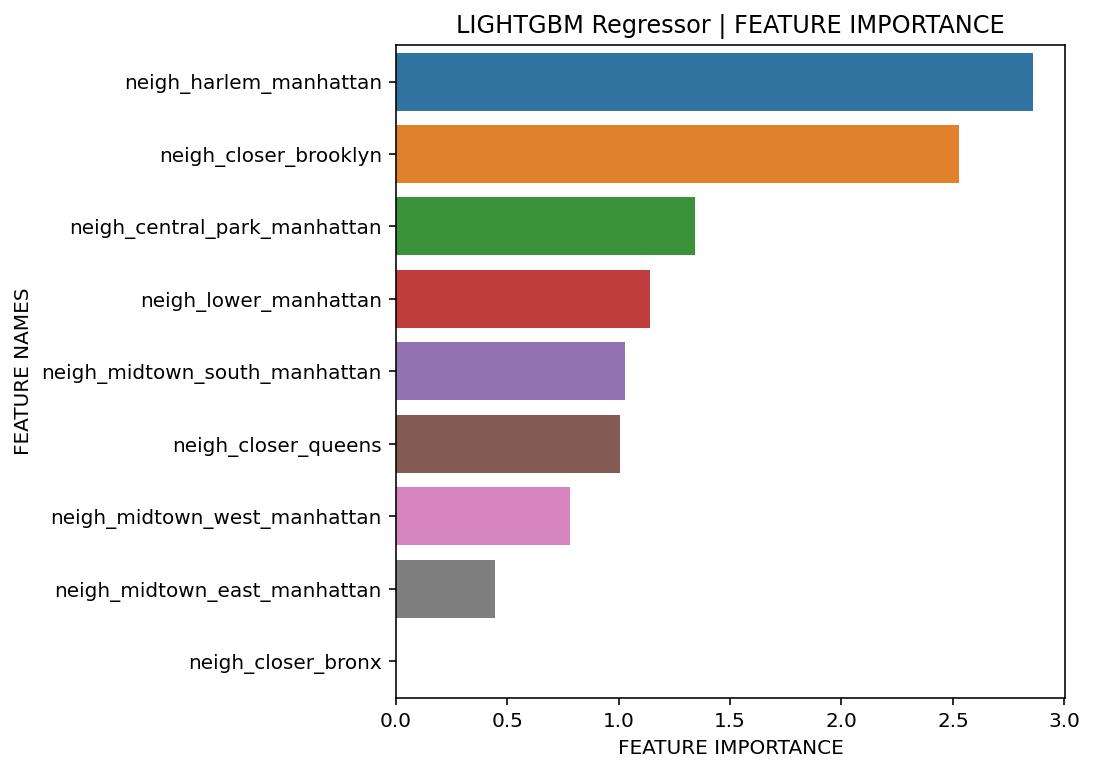

In [ ]:
name_df = var_df[var_df.pcols.str.startswith('neigh_')]

plot_features(name_df,'LGBM Regressor - Neighbourhood Grouped')

Unfortunately we cannot interpret whether these importance features influence the price in a positive way.

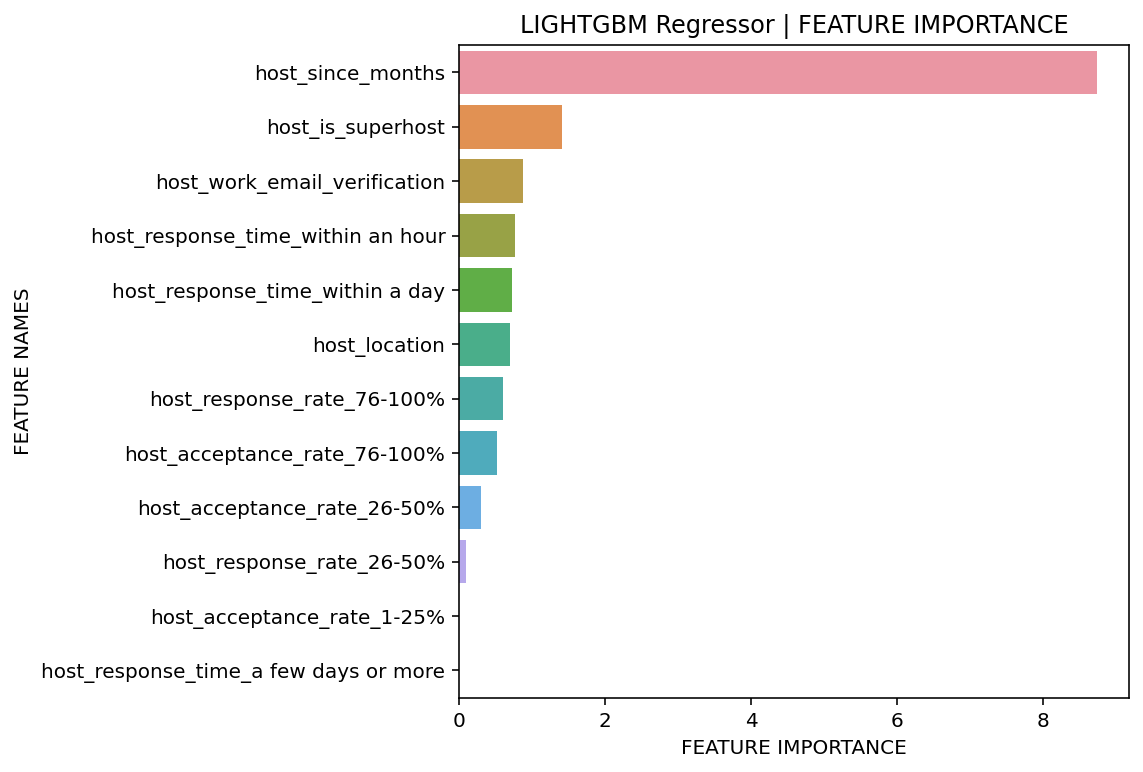

In [ ]:
host_df = var_df[var_df.pcols.str.startswith('host_')]

plot_features(host_df,'LGBM Regressor - Host Related')

Consistency and professionalism is very important. The customer request messages should be replied within an hour.

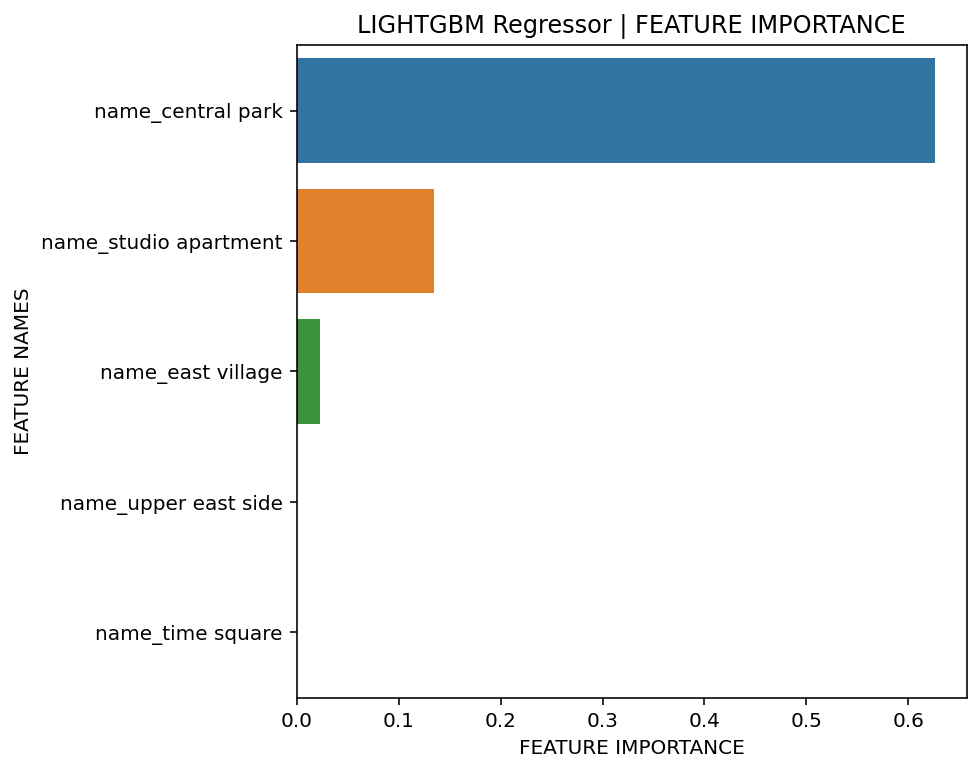

In [ ]:
name_df = var_df[var_df.pcols.str.startswith('name_')]

plot_features(name_df,'LGBM Regressor - Listing Title NLP')

We cannot interpret if the landmarks or these neighborhoods have a positive impact on the price. We will figure it out soon.

-----

SHAP package will be helpful to interpret the features:

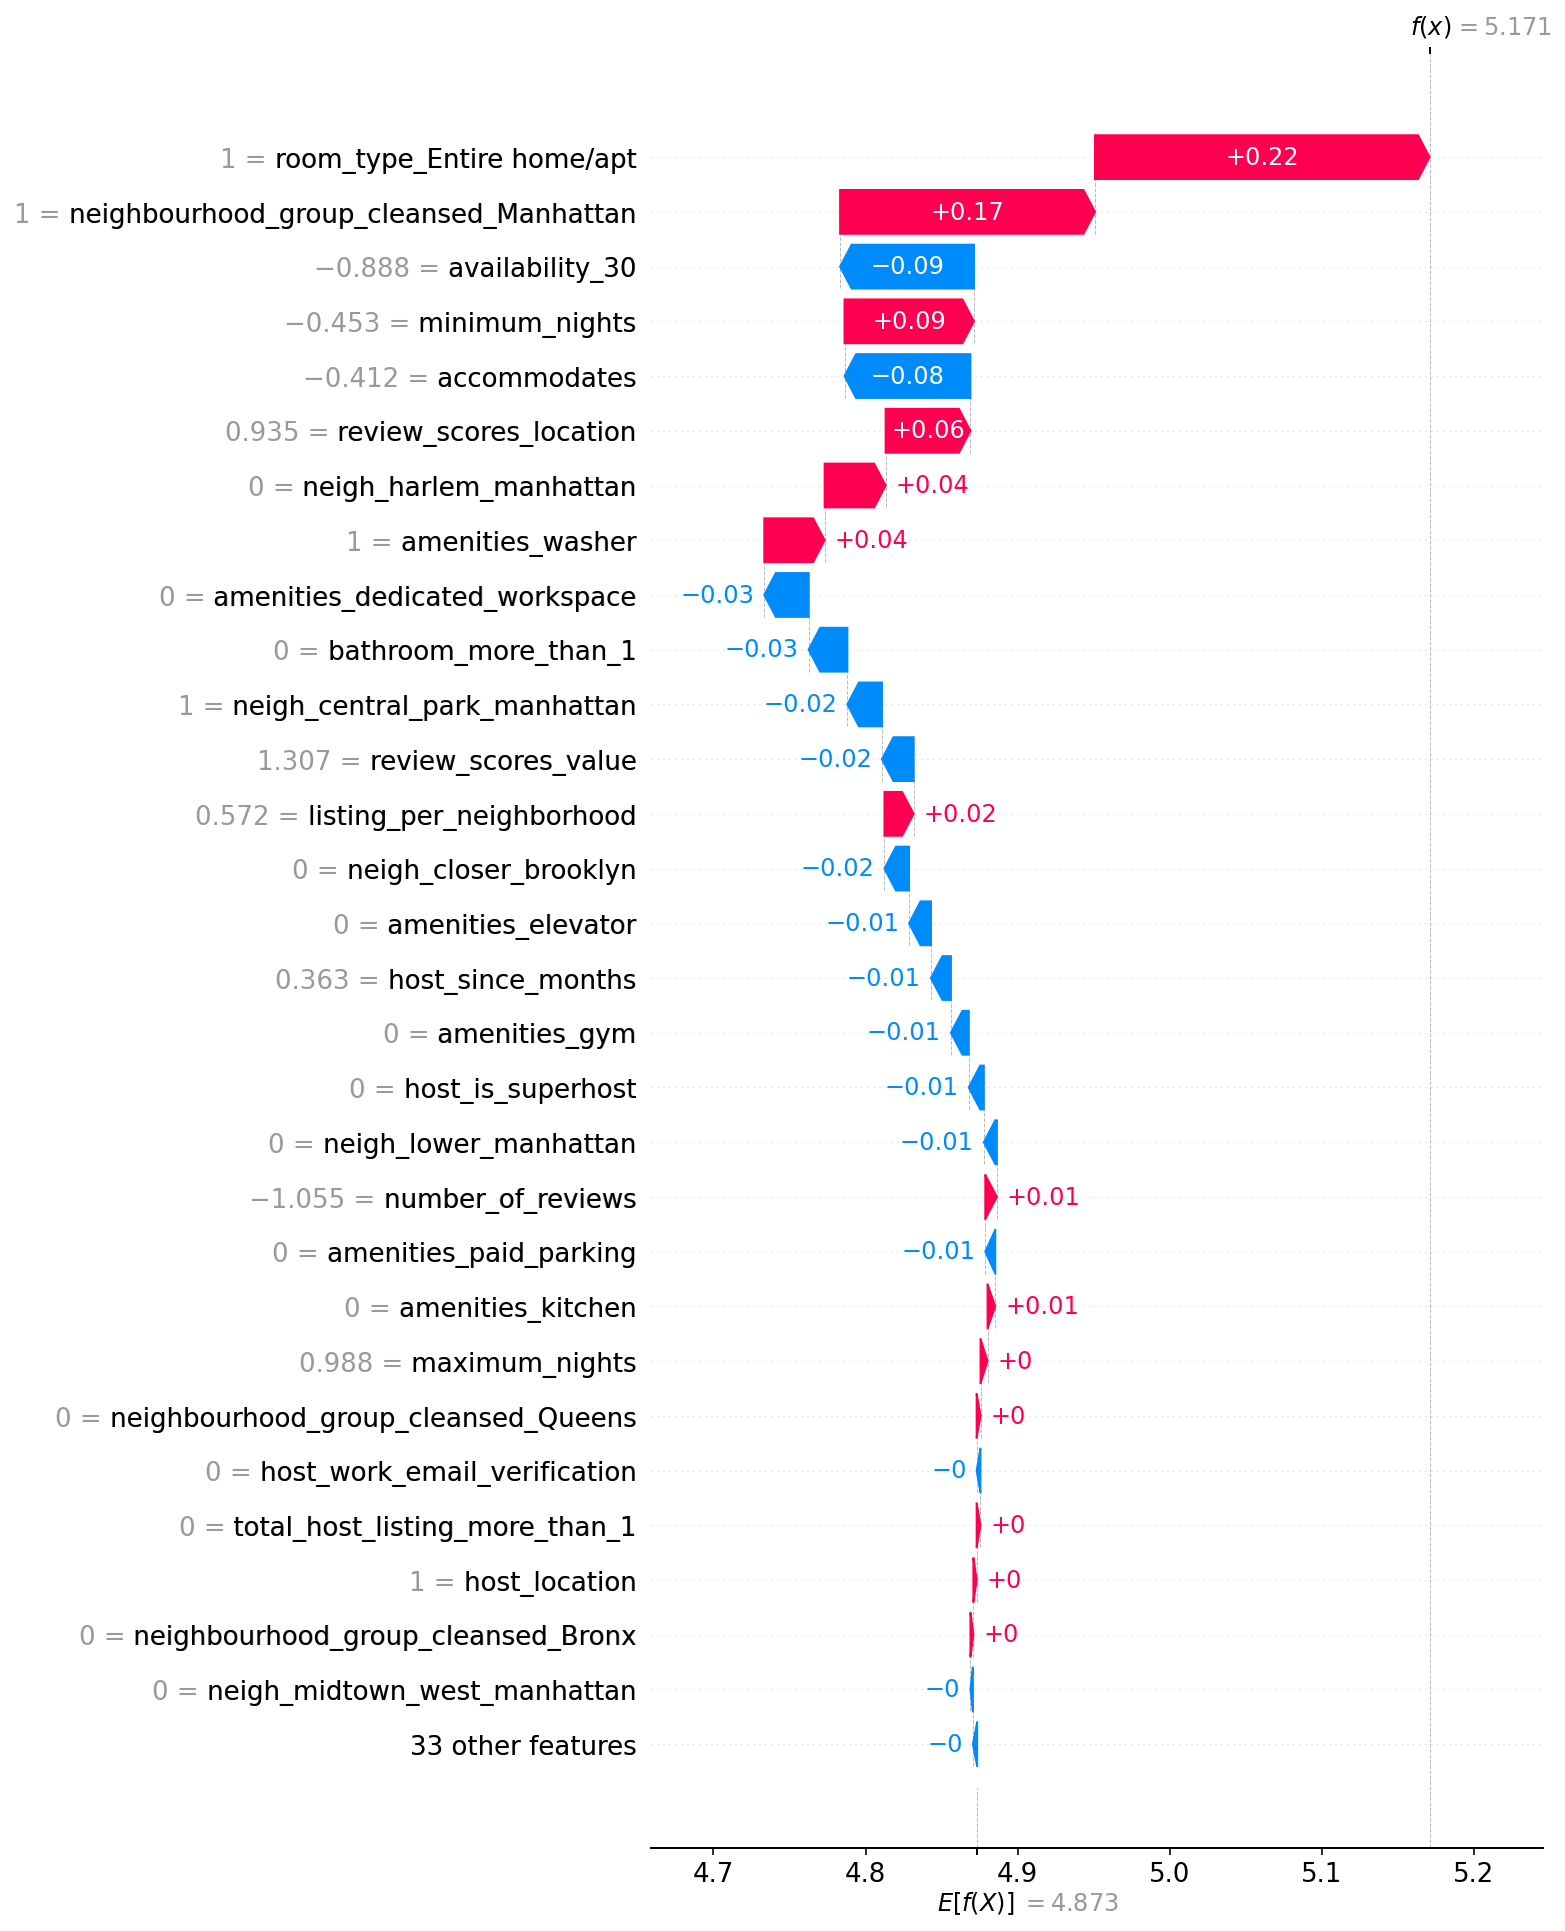

In [ ]:
import shap


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(optimal_lgbm)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=30)

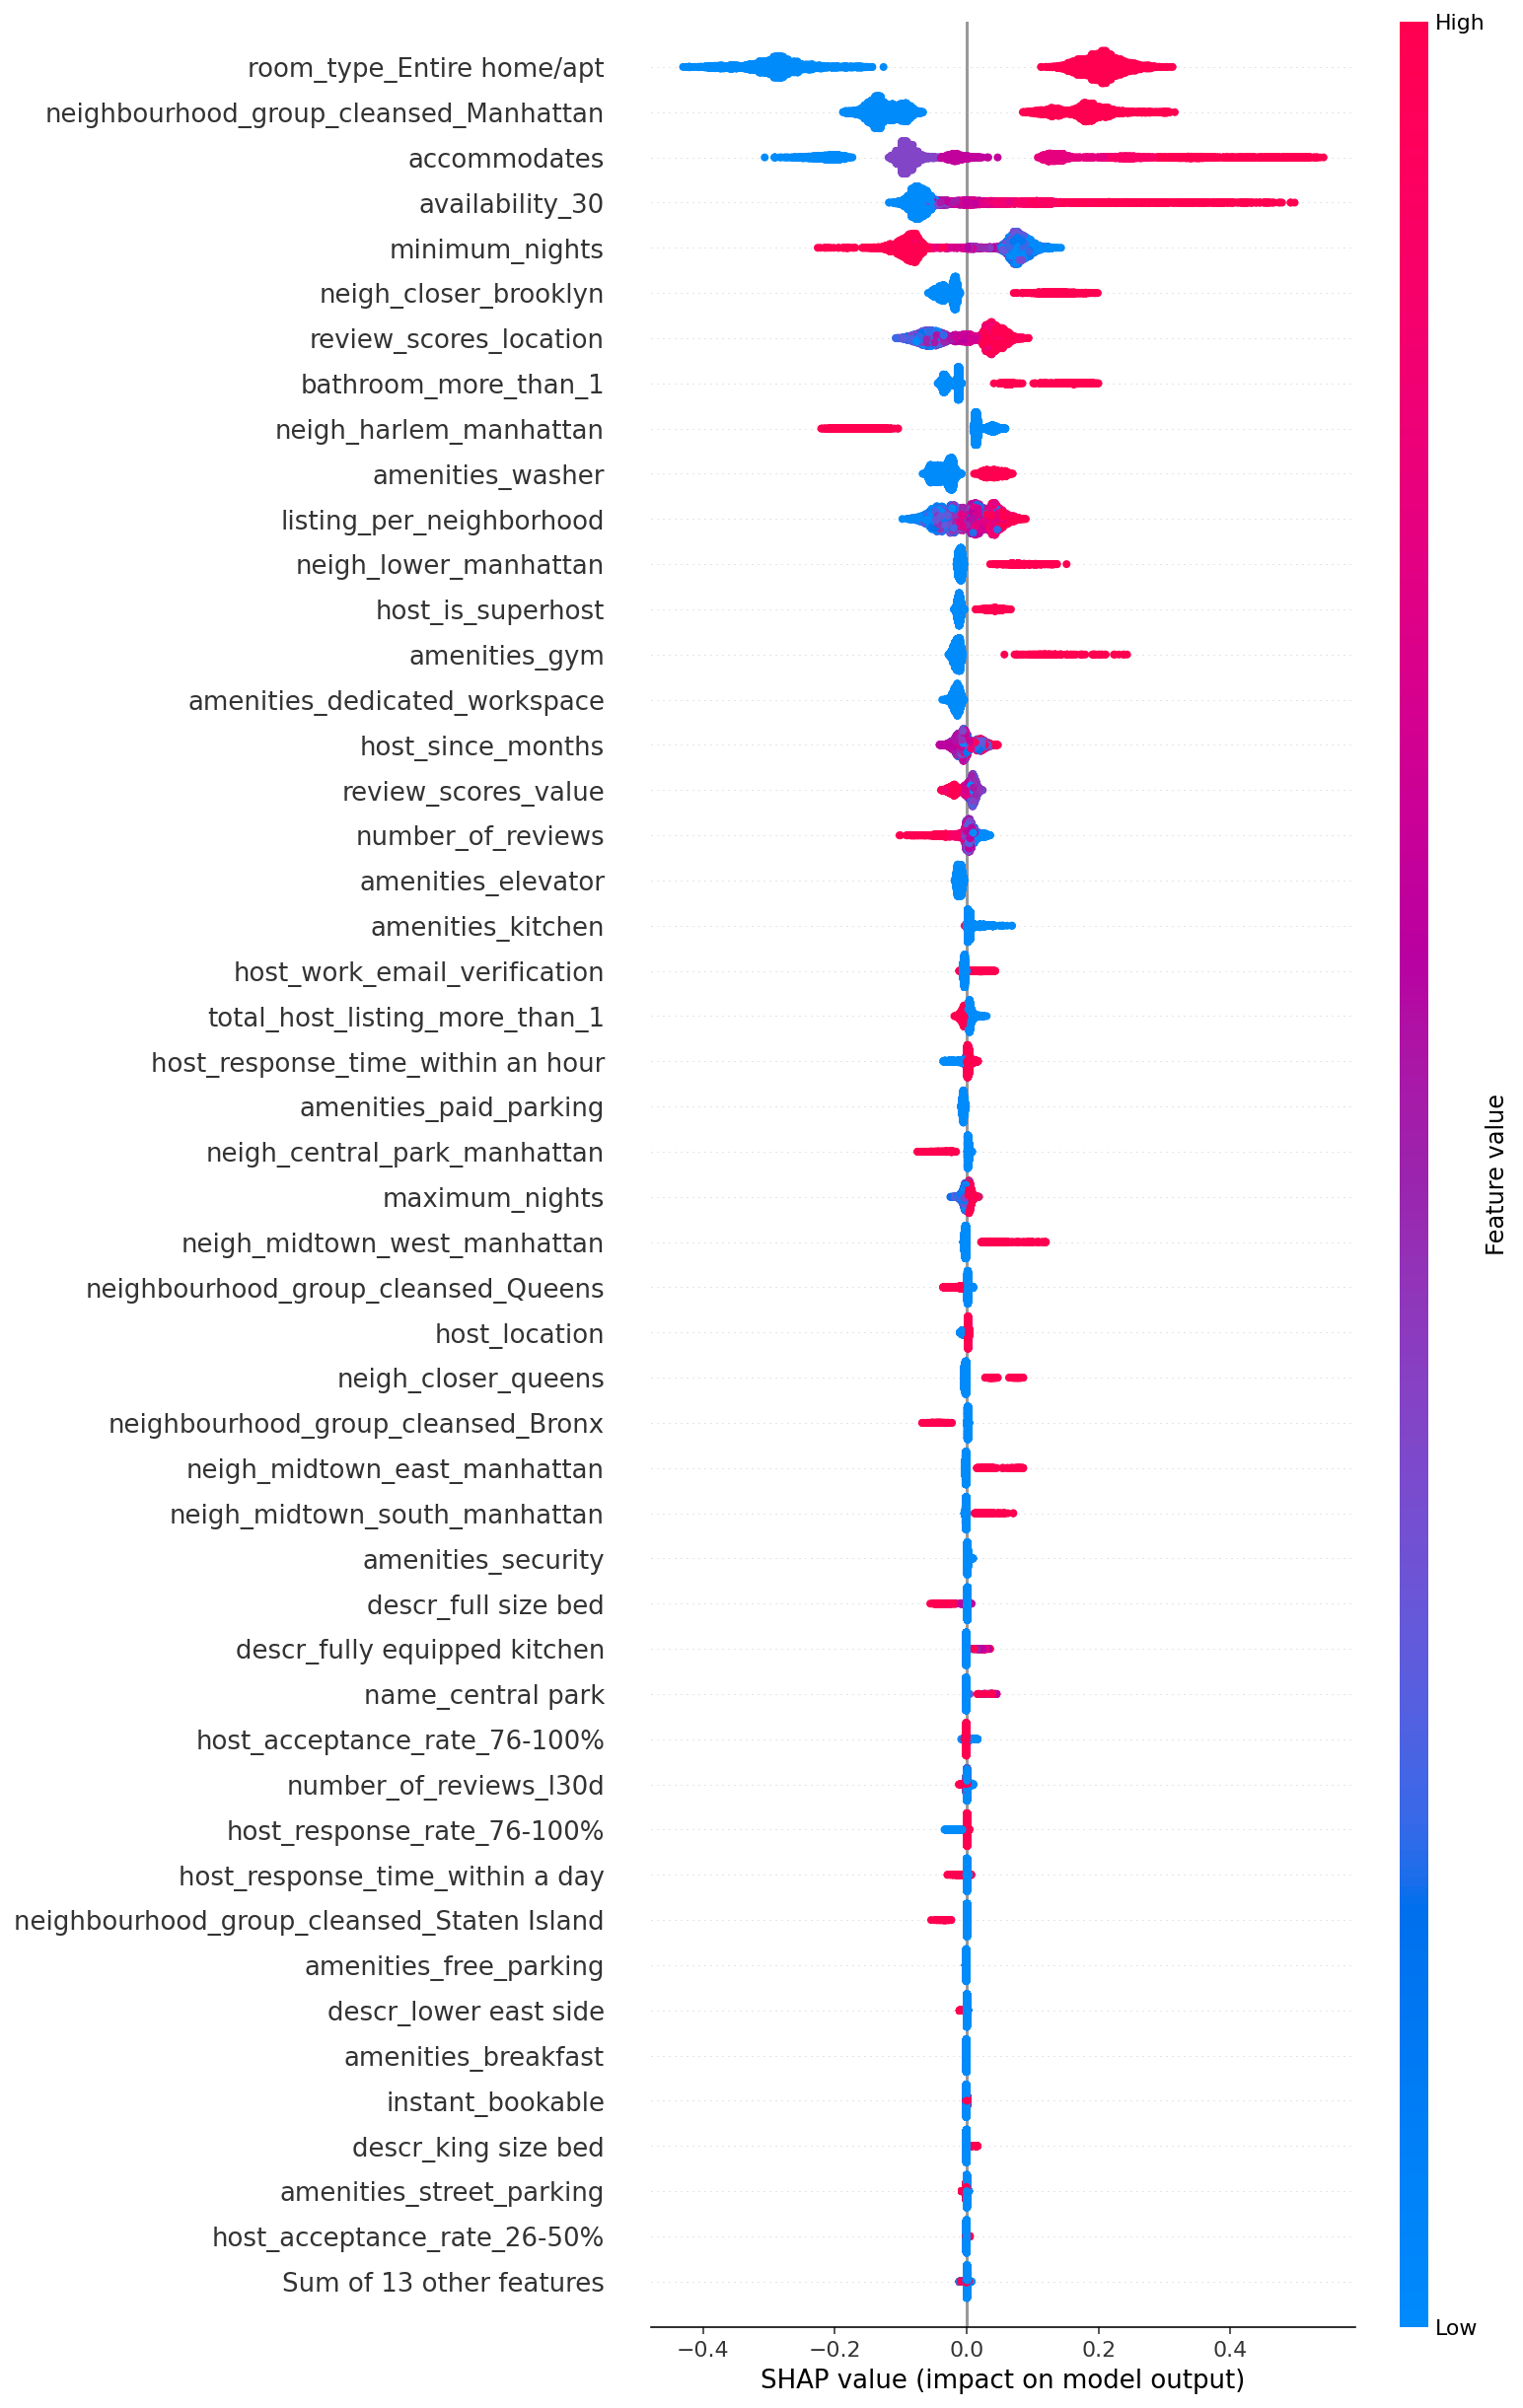

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values,max_display=50)

Amazing! Shap plot sums up everything and supports the findings that we have gained during Lasso Modeling. The left side shows the negative correlation while the right side represent the positive correlation between the attributes and the target value. The blue color shows when the value of the that feature is low while the red one is strong.


- Entire home
- Manhattan & Brooklyn neighborhoods closer to Manhattan
- Gym
- More than 1 bathroom
- Washer
- Listing per neighborhood (Competition)
- Higher number of accommodates
- Less availability within 30 days 

are the the key features when determining the listing prices.


-	Surprisingly the listings with a higher number of reviews or places around Central Park including Upper East or West Side tend to be at a lower price.

- As a host owns more than one property, he/she may have a room to reduce the price as shown in the plot.

Again, we are glad to see our engineered features here. Feature selection could be the next step. 

In [ ]:
results_table2

""
Model
R^2
MAE


## **Closing Remarks:**



---


Sole contributor: Aslinur Acarlioglu

Date: August 28, 2022

Notebook: 4 of 4